In [1]:
from matplotlib import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# light theme
plt.style.use("default")

filename = "/data/kebl6672/dpo-toxic-general/toxicity/gpt2_all_neuron_metrics.csv"

df = pd.read_csv(filename)

In [2]:
df.head()

,layer_idx,neuron_idx,pt_projection_value,dpo_projection_value,pt_activation_value,dpo_activation_value,pt_cossim,dpo_cossim,gpt2_value_vector_projs,dpo_value_vector_projs,projection_diff,activation_diff
0,0,0,-0.004434,-0.004821,-0.086628,-0.094152,0.020808,0.020818,0.051181,0.051206,3.874512e-04,0.007524
1,0,1,0.000381,0.000381,-0.010077,-0.010096,-0.015356,-0.015325,-0.037849,-0.037771,7.888138e-08,0.000019
2,0,2,0.008536,0.008656,-0.065236,-0.066241,-0.044885,-0.044824,-0.130852,-0.130673,-1.195893e-04,0.001005
3,0,3,0.004260,0.004129,-0.081713,-0.079245,-0.015817,-0.015809,-0.052139,-0.052108,1.311275e-04,-0.002468
4,0,4,0.000003,-0.000003,-0.073461,-0.079985,-0.000018,0.000015,-0.000046,0.000038,6.465025e-06,0.006524


In [3]:
# Count rows where projection_diff is positive
positive_count = (df["projection_diff"] > 0).sum()

# Total number of rows
total_count = len(df)

# Compute percentage
percentage_positive = (positive_count / total_count) * 100

print(positive_count)
print(f"Percentage of rows with positive projection_diff: {percentage_positive:.2f}%")

57501
Percentage of rows with positive projection_diff: 58.49%


In [4]:
# Total number of activations
total = len(df)

# Count positive and negative activations
num_positive = (df["pt_activation_value"] > 0).sum()
num_negative = (df["pt_activation_value"] < 0).sum()

# Compute percentages
percent_positive = (num_positive / total) * 100
percent_negative = (num_negative / total) * 100

# Print results
print(f"Positive activations: {percent_positive:.2f}%")
print(f"Negative activations: {percent_negative:.2f}%")


Positive activations: 12.71%
Negative activations: 87.28%


In [5]:
# Calculate the sum of non-negative values of 'projection_diff'
sum_non_negative = df[df['projection_diff'] >= 0]['projection_diff'].sum()

# Calculate the sum of all values of 'projection_diff'
sum_all = df['projection_diff'].sum()

# Print the results
print(f"Sum of non-negative values: {sum_non_negative}")
print(f"Sum of all values: {sum_all}")

Sum of non-negative values: 47.96267586110679
Sum of all values: 7.216442956175582


#### Appendix activation graph

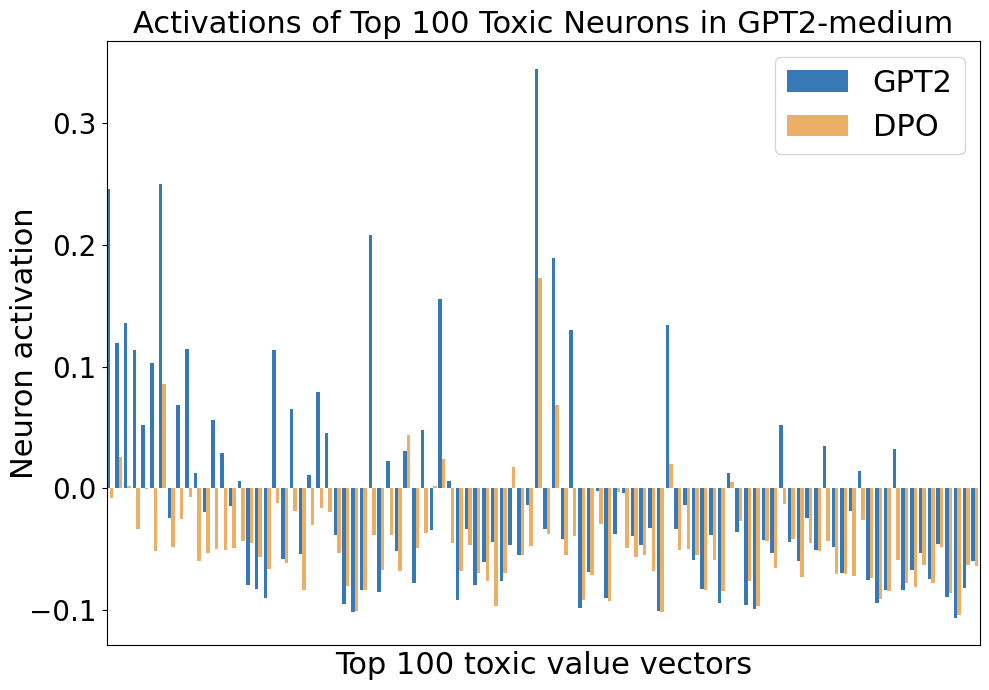

In [38]:
# Step 1: Select top 100 toxic neurons by cosine similarity
top_toxic = df.sort_values(by="pt_cossim", ascending=False).head(100)

# Step 2: Extract activation values
gpt2_activations = top_toxic["pt_activation_value"].values
dpo_activations = top_toxic["dpo_activation_value"].values

# Step 3: Plot
x = np.arange(len(top_toxic))  # x positions for 100 neurons
width = 0.4  # Width of the bars

plt.figure(figsize=(10, 7))
plt.bar(x - width/2, gpt2_activations, width=width, label="GPT2", color="#3679B5")
plt.bar(x + width/2, dpo_activations, width=width, label="DPO", color="#ECAF65")

plt.xlabel("Top 100 toxic value vectors", fontsize=22)
plt.ylabel("Neuron activation", fontsize=22, labelpad=-7)
plt.title("Activations of Top 100 Toxic Neurons in GPT2-medium", fontsize=22)
plt.legend(fontsize=22)
plt.xticks([], [])  # Hide x-axis tick labels
plt.yticks(fontsize=20)

# Remove space before and after bars
plt.xlim(-0.4, len(top_toxic) - 0.4)

plt.tight_layout()
plt.show()

#### Are projection changes random by cossim?

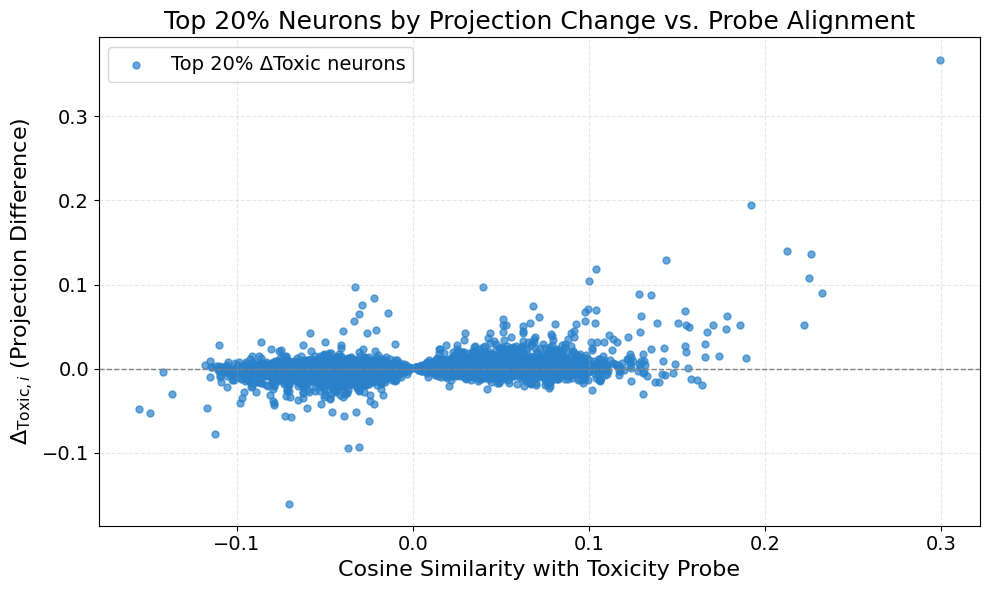

In [4]:
# Step 1: Compute absolute projection difference
df["abs_proj_diff"] = df["projection_diff"].abs()

# Step 2: Compute threshold for top 20%
threshold = df["abs_proj_diff"].quantile(0.80)

# Step 3: Filter for top 20% neurons
top_20_df = df[df["abs_proj_diff"] >= threshold]

# Step 4: Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    top_20_df["pt_cossim"],
    top_20_df["projection_diff"],
    alpha=0.7,
    s=25,
    color="#2A81CA",
    label="Top 20% ΔToxic neurons"
)

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Cosine Similarity with Toxicity Probe", fontsize=18)
plt.ylabel(r"$\Delta_{\mathrm{Toxic}, i}$ (Projection Difference)", fontsize=18)
plt.title("Top 20% Neurons by Projection Change vs. Probe Alignment", fontsize=20)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()


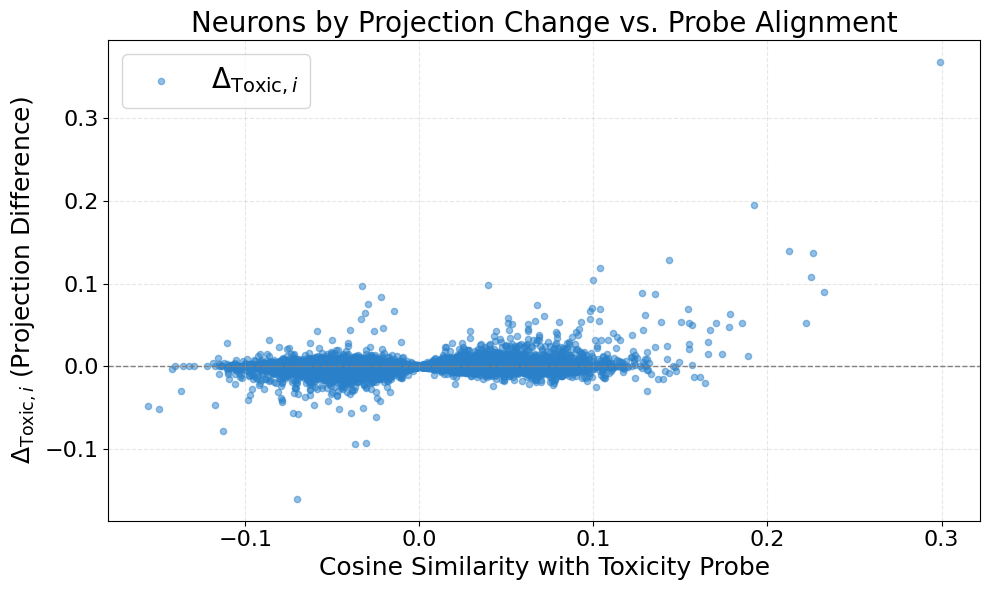

In [9]:
plt.figure(figsize=(10, 6))

# Scatter plot: cosine similarity vs. projection difference
plt.scatter(df["pt_cossim"], df["projection_diff"],
            alpha=0.5, s=20, color="#2A81CA", label=r"$\Delta_{\mathrm{Toxic}, i}$")

# Plot zero line for reference
plt.axhline(0, color="gray", linestyle="--", linewidth=1)

plt.xlabel("Cosine Similarity with Toxicity Probe", fontsize=18)
plt.ylabel(r"$\Delta_{\mathrm{Toxic}, i}$ (Projection Difference)", fontsize=18)
plt.title("Neurons by Projection Change vs. Probe Alignment", fontsize=20)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)

plt.tight_layout()
plt.show()


#### Per-layer plots

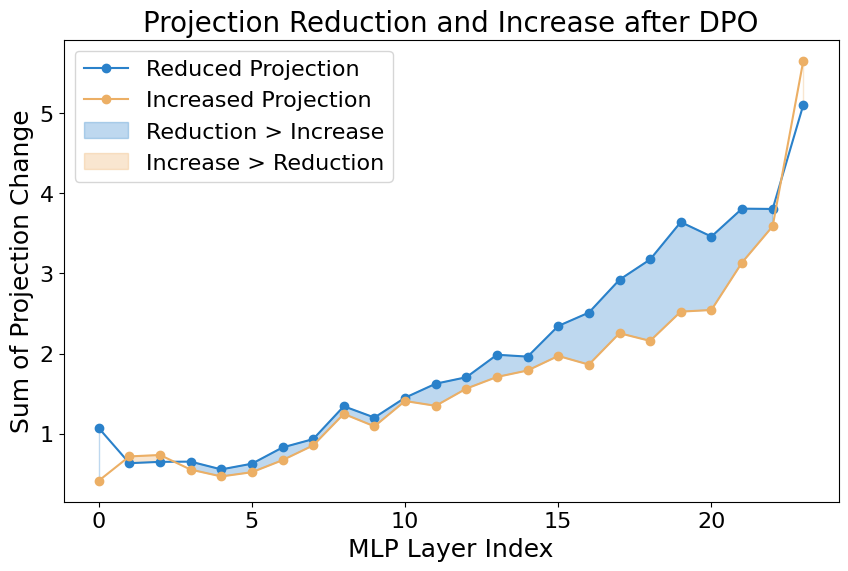

In [5]:
# Compute per-layer sum of positive and negative projection differences separately
layer_sums = df.groupby("layer_idx")[["pt_projection_value", "dpo_projection_value"]].sum().reset_index()

# Compute projection difference at the neuron level before summing at the layer level
df["projection_diff"] = df["pt_projection_value"] - df["dpo_projection_value"]

# Aggregate separately for positive and negative projection differences
positive_projection_sums = df[df["projection_diff"] > 0].groupby("layer_idx")["projection_diff"].sum().reset_index()
negative_projection_sums = df[df["projection_diff"] < 0].groupby("layer_idx")["projection_diff"].sum().abs().reset_index()

# Merge with the main layer index to ensure all layers are represented
layer_sums = layer_sums[["layer_idx"]].merge(positive_projection_sums, on="layer_idx", how="left").merge(
    negative_projection_sums, on="layer_idx", how="left", suffixes=("_positive", "_negative")
)

# Fill NaN values with 0 (for layers with no positive or negative values)
layer_sums.fillna(0, inplace=True)

# Plot the data as line charts with shading between them
plt.figure(figsize=(10, 6))

# Plot positive and negative projection differences as line plots
plt.plot(layer_sums["layer_idx"], layer_sums["projection_diff_positive"], 
         label="Reduced Projection", color="#2A81CA", marker='o', linestyle='-')
plt.plot(layer_sums["layer_idx"], layer_sums["projection_diff_negative"], 
         label="Increased Projection", color="#ECAF65", marker='o', linestyle='-')

# Fill the area between the two lines
plt.fill_between(layer_sums["layer_idx"], layer_sums["projection_diff_positive"], 
                 layer_sums["projection_diff_negative"],
                 where=(layer_sums["projection_diff_positive"] > layer_sums["projection_diff_negative"]), 
                 color="#2A81CA", alpha=0.3, label="Reduction > Increase")

plt.fill_between(layer_sums["layer_idx"], layer_sums["projection_diff_positive"], 
                 layer_sums["projection_diff_negative"],
                 where=(layer_sums["projection_diff_positive"] < layer_sums["projection_diff_negative"]), 
                 color="#ECAF65", alpha=0.3, label="Increase > Reduction")

# plt.fill_between(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_negative"], 
#                  0, color="#ECAF65", alpha=0.2, label="Under Increased Projection")

plt.xlabel("MLP Layer Index", fontsize=18)
plt.ylabel("Sum of Projection Change", fontsize=18)
plt.title("Projection Reduction and Increase after DPO", fontsize=20)
# plt.xticks(layer_sums["layer_idx"], fontsize=16)  
plt.xticks(np.arange(min(layer_sums["layer_idx"]), max(layer_sums["layer_idx"]) + 1, 5), fontsize=16) 
plt.yticks(fontsize=16)  
plt.legend(fontsize=16)

plt.show()


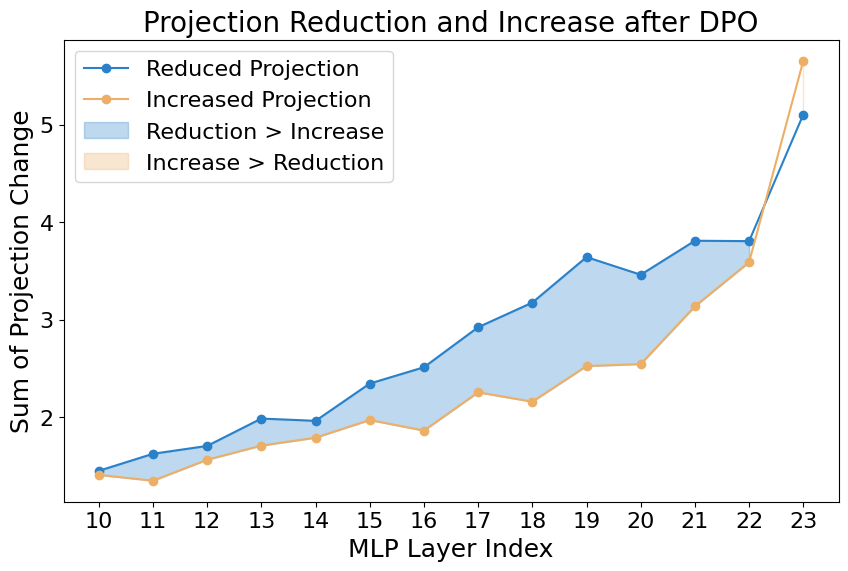

In [6]:
# Filter the data to show only layer 10 onwards
layer_sums_filtered = layer_sums[layer_sums["layer_idx"] >= 10]

# Plot the data as line charts with shading between them
plt.figure(figsize=(10, 6))

# Plot positive and negative projection differences as line plots
plt.plot(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_positive"], 
         label="Reduced Projection", color="#2A81CA", marker='o', linestyle='-')
plt.plot(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_negative"], 
         label="Increased Projection", color="#ECAF65", marker='o', linestyle='-')

# Fill the area between the two lines
plt.fill_between(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_positive"], 
                 layer_sums_filtered["projection_diff_negative"],
                 where=(layer_sums_filtered["projection_diff_positive"] > layer_sums_filtered["projection_diff_negative"]), 
                 color="#2A81CA", alpha=0.3, label="Reduction > Increase")

plt.fill_between(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_positive"], 
                 layer_sums_filtered["projection_diff_negative"],
                 where=(layer_sums_filtered["projection_diff_positive"] < layer_sums_filtered["projection_diff_negative"]), 
                 color="#ECAF65", alpha=0.3, label="Increase > Reduction")

# plt.fill_between(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_negative"], 
#                  0, color="#ECAF65", alpha=0.2, label="Under Increased Projection")

plt.xlabel("MLP Layer Index", fontsize=18)
plt.ylabel("Sum of Projection Change", fontsize=18)
plt.title("Projection Reduction and Increase after DPO", fontsize=20)
plt.xticks(layer_sums_filtered["layer_idx"], fontsize=16)  
plt.yticks(fontsize=16)  
plt.legend(fontsize=16)

plt.show()

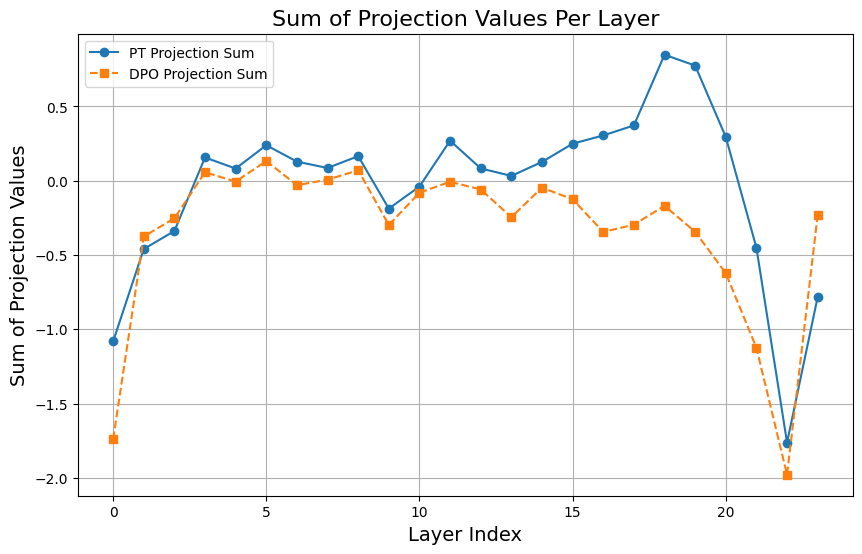

In [7]:
# Group by layer_index and compute the sum for pt_projection_value and dpo_projection_value
layer_sums = df.groupby("layer_idx")[["pt_projection_value", "dpo_projection_value"]].sum().reset_index()
# print(layer_sums)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot PT projection sum
plt.plot(layer_sums["layer_idx"], layer_sums["pt_projection_value"], label="PT Projection Sum", marker='o', linestyle='-')

# Plot DPO projection sum
plt.plot(layer_sums["layer_idx"], layer_sums["dpo_projection_value"], label="DPO Projection Sum", marker='s', linestyle='--')

# Labels and title
plt.xlabel("Layer Index", fontsize=14)
plt.ylabel("Sum of Projection Values", fontsize=14)
plt.title("Sum of Projection Values Per Layer", fontsize=16)
plt.legend()
plt.grid(True)

# Show plot
plt.show()


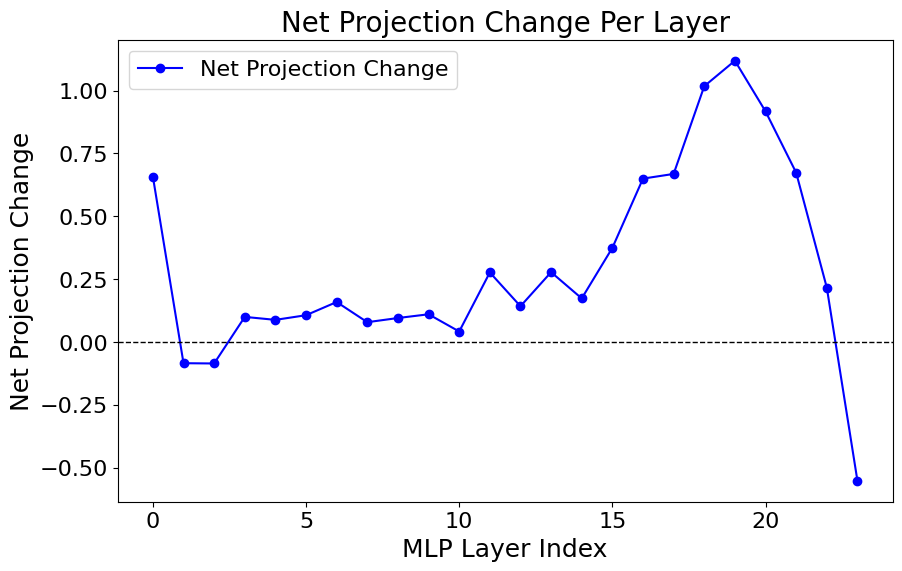

In [8]:
# Compute per-layer projection difference
layer_sums = df.groupby("layer_idx")[["pt_projection_value", "dpo_projection_value"]].sum().reset_index()

layer_sums["projection_diff"] = layer_sums["pt_projection_value"] - layer_sums["dpo_projection_value"]

# Plot the data
plt.figure(figsize=(10, 6))

# Plot Projection Difference
plt.plot(layer_sums["layer_idx"], layer_sums["projection_diff"], label="Net Projection Change", marker='o', linestyle='-', color='blue')

# Add a horizontal line at y=0 for reference
plt.axhline(0, color="black", linestyle="--", linewidth=1)
# plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.8)  # Lighter gray grid

# Labels and title
plt.xlabel("MLP Layer Index", fontsize=18)
plt.ylabel("Net Projection Change", fontsize=18)
plt.title("Net Projection Change Per Layer", fontsize=20)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  

# Show plot
plt.show()

##### Cumulative sum plot

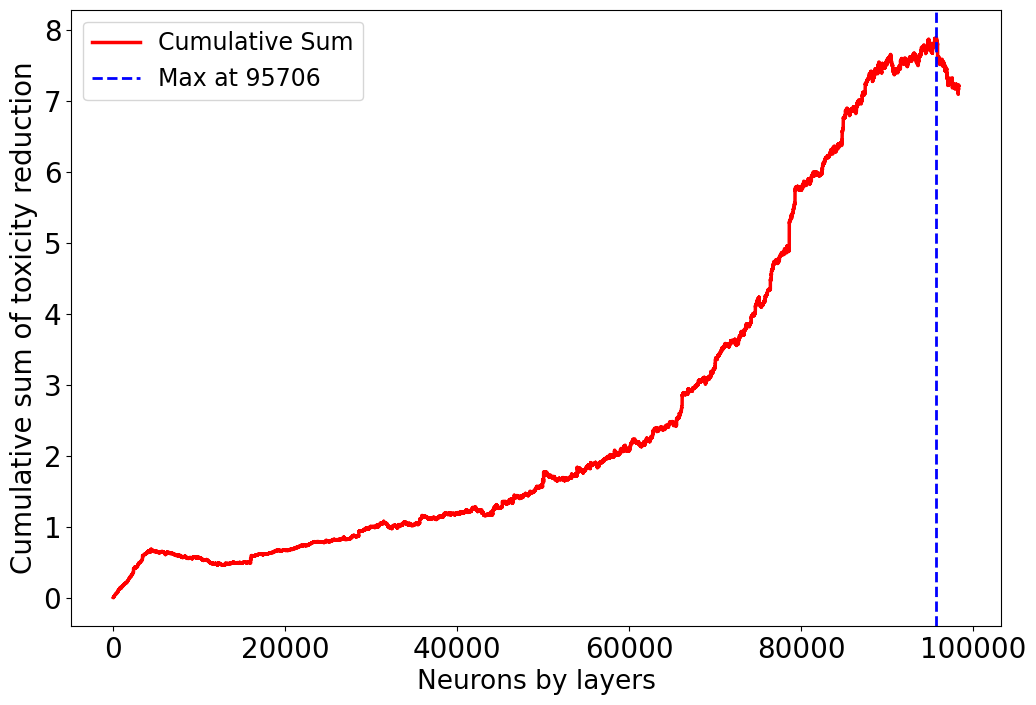

In [9]:
# Initialize an empty list for the cumulative sum
cumsum_values = []

# Manually calculate the cumulative sum
current_sum = 0
for value in df['projection_diff']:
    current_sum += value
    cumsum_values.append(current_sum)

# Find the index where the cumulative sum reaches its maximum
max_cumsum_index = np.argmax(cumsum_values)

# Plot the manually calculated cumulative sum
plt.figure(figsize=(12, 8))
plt.plot(cumsum_values, label='Cumulative Sum', color='r', linewidth=2.5)  # Increased linewidth

# Add a vertical line at the maximum cumulative sum
plt.axvline(x=max_cumsum_index, color='b', linestyle='--', linewidth=2, label=f'Max at {max_cumsum_index}')  # Increased linewidth

# Add labels and title
# plt.title("Cumulative sum of toxicity reduction contributed by neurons", fontsize=18)
plt.xlabel("Neurons by layers", fontsize=19)
plt.ylabel("Cumulative sum of toxicity reduction", fontsize=20)

# Increase tick label sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add legend
plt.legend(fontsize=17)

# Show the plot
# plt.grid(True)
plt.show()

In [8]:
df = df.sort_values(by="projection_diff", ascending=False)

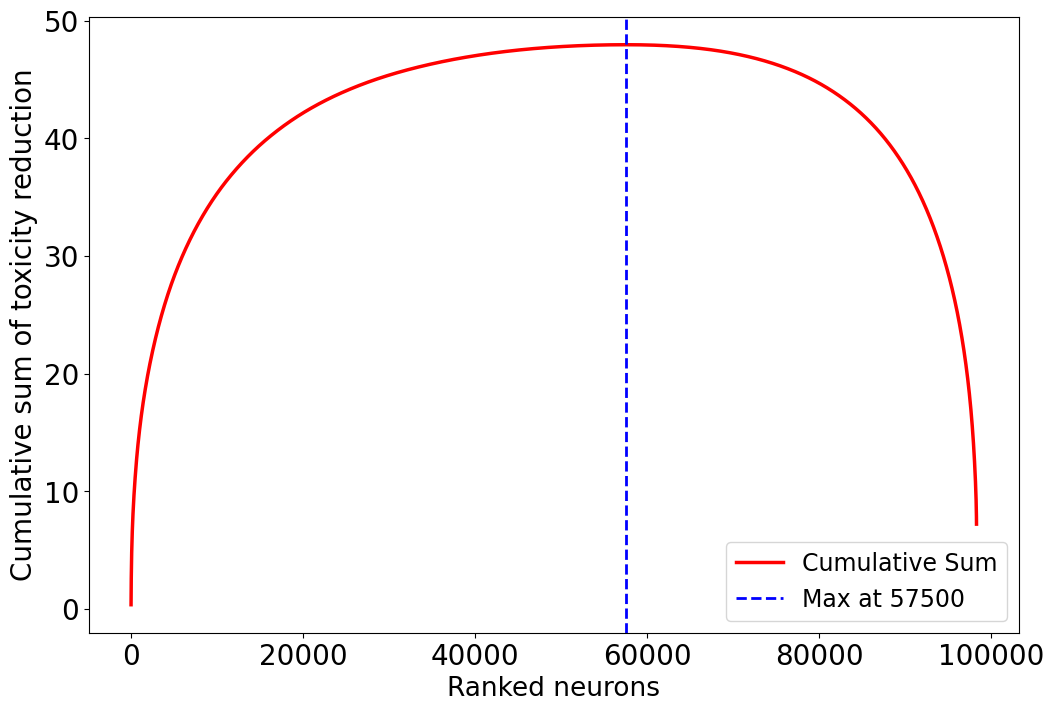

In [34]:
# Initialize an empty list for the cumulative sum
cumsum_values = []

# Manually calculate the cumulative sum
current_sum = 0
for value in df['projection_diff']:
    current_sum += value
    cumsum_values.append(current_sum)

# Find the index where the cumulative sum reaches its maximum
max_cumsum_index = np.argmax(cumsum_values)

# Plot the manually calculated cumulative sum
plt.figure(figsize=(12, 8))
plt.plot(cumsum_values, label='Cumulative Sum', color='r', linewidth=2.5)  # Increased linewidth

# Add a vertical line at the maximum cumulative sum
plt.axvline(x=max_cumsum_index, color='b', linestyle='--', linewidth=2, label=f'Max at {max_cumsum_index}')  # Increased linewidth

# Add labels and title
# plt.title("Cumulative sum of toxicity reduction contributed by neurons", fontsize=18)
plt.xlabel("Ranked neurons", fontsize=19)
plt.ylabel("Cumulative sum of toxicity reduction", fontsize=20)

# Increase tick label sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add legend
plt.legend(fontsize=17)

# Show the plot
# plt.grid(True)
plt.show()

##### Array plot

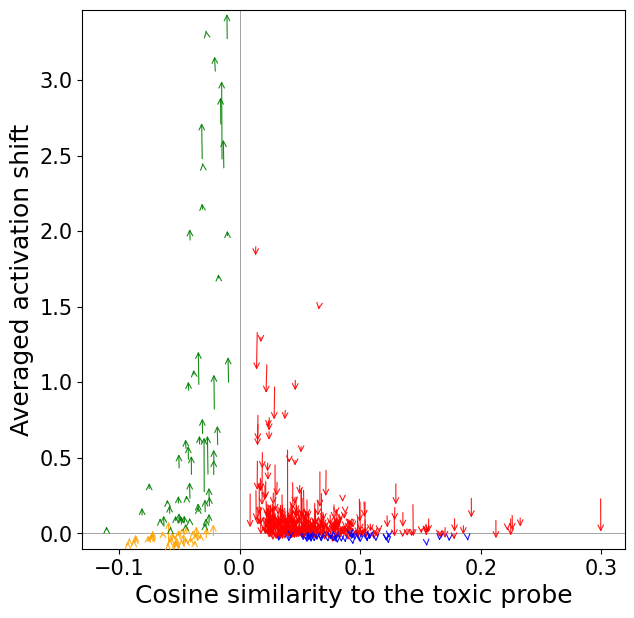

In [22]:
# Top contributing neurons
top_contrib = df.sort_values(by="projection_diff", ascending=False).head(500)

# Define x and y variables
x1 = top_contrib["pt_cossim"]
x2 = top_contrib["dpo_cossim"]

# Activation shift outlier removal for display
lower_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.005).min()
upper_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.995).max()

top_contrib = top_contrib[
    (top_contrib["pt_activation_value"].between(lower_q, upper_q)) &
    (top_contrib["dpo_activation_value"].between(lower_q, upper_q))
]

# - toxic neurons: positive cossim + activation drop
# - anti-toxic neurons: negative cossim + activation rise
top_contrib = top_contrib[
    ((top_contrib["pt_cossim"] > 0) & (top_contrib["dpo_activation_value"] < top_contrib["pt_activation_value"])) |
    ((top_contrib["pt_cossim"] < 0) & (top_contrib["dpo_activation_value"] > top_contrib["pt_activation_value"]))
]

# Final inputs for plot
x1 = top_contrib["pt_cossim"]
x2 = top_contrib["dpo_cossim"]
y1 = top_contrib["pt_activation_value"]
y2 = top_contrib["dpo_activation_value"]

# Use raw contribution values for line width
contrib = top_contrib["projection_diff"]
width_boost = 1.2
width = contrib * width_boost  # optionally scale if desired

fig, ax = plt.subplots(figsize=(7, 7))

# Increase label font size
ax.set_xlabel("Cosine similarity to the toxic probe", fontsize=18)
ax.set_ylabel("Averaged activation shift", fontsize=18)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=15)

_xpad = 0.02
_ypad = 0.01
ax.set_xlim(min(min(x1), min(x2)) - _xpad, max(max(x1), max(x2)) + _xpad)
ax.set_ylim(min(min(y1), min(y2)) - _ypad, max(max(y1), max(y2)) + _ypad)

ax.axhline(0, color="gray", lw=0.5)
ax.axvline(0, color="gray", lw=0.5)

for _x1, _x2, _y1, _y2, _contrib, _width in zip(x1, x2, y1, y2, contrib, width):
    if _x1 > 0:
        if _y1 > 0:
            color = "r"  # toxic neuron with positive activation
        else:
            color = "b"  # toxic neuron with negative activation
    else:
        if _y1 > 0:
            color = "g"  # anti-toxic neuron with positive activation
        else:
            color = "orange"  # anti-toxic neuron with negative activation

    ax.annotate(
        "",
        xy=(_x2, _y2),
        xytext=(_x1, _y1),
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            alpha=0.9,  # Add transparency
            linewidth=max(_width, 0.8),  # Ensure line is not too thin
        ),
    )


plt.show()


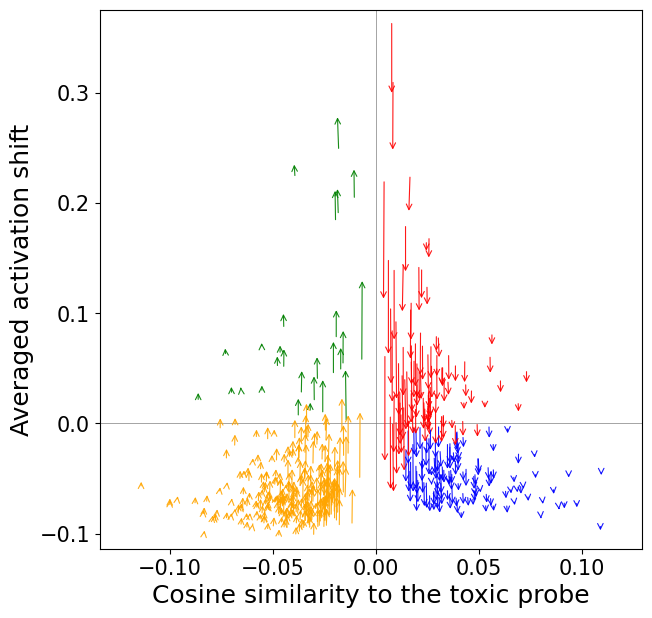

In [24]:
# Top contributing neurons
top_contrib = df.sort_values(by="projection_diff", ascending=False).iloc[4000:4500]

# Define x and y variables
x1 = top_contrib["pt_cossim"]
x2 = top_contrib["dpo_cossim"]

# Activation shift outlier removal for display
lower_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.005).min()
upper_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.995).max()

top_contrib = top_contrib[
    (top_contrib["pt_activation_value"].between(lower_q, upper_q)) &
    (top_contrib["dpo_activation_value"].between(lower_q, upper_q))
]

# - toxic neurons: positive cossim + activation drop
# - anti-toxic neurons: negative cossim + activation rise
top_contrib = top_contrib[
    ((top_contrib["pt_cossim"] > 0) & (top_contrib["dpo_activation_value"] < top_contrib["pt_activation_value"])) |
    ((top_contrib["pt_cossim"] < 0) & (top_contrib["dpo_activation_value"] > top_contrib["pt_activation_value"]))
]

# Final inputs for plot
x1 = top_contrib["pt_cossim"]
x2 = top_contrib["dpo_cossim"]
y1 = top_contrib["pt_activation_value"]
y2 = top_contrib["dpo_activation_value"]

# Use raw contribution values for line width
contrib = top_contrib["projection_diff"]
width_boost = 1.2
width = contrib * width_boost  # optionally scale if desired

fig, ax = plt.subplots(figsize=(7, 7))

# Increase label font size
ax.set_xlabel("Cosine similarity to the toxic probe", fontsize=18)
ax.set_ylabel("Averaged activation shift", fontsize=18)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=15)

_xpad = 0.02
_ypad = 0.01
ax.set_xlim(min(min(x1), min(x2)) - _xpad, max(max(x1), max(x2)) + _xpad)
ax.set_ylim(min(min(y1), min(y2)) - _ypad, max(max(y1), max(y2)) + _ypad)

ax.axhline(0, color="gray", lw=0.5)
ax.axvline(0, color="gray", lw=0.5)

for _x1, _x2, _y1, _y2, _contrib, _width in zip(x1, x2, y1, y2, contrib, width):
    if _x1 > 0:
        if _y1 > 0:
            color = "r"  # toxic neuron with positive activation
        else:
            color = "b"  # toxic neuron with negative activation
    else:
        if _y1 > 0:
            color = "g"  # anti-toxic neuron with positive activation
        else:
            color = "orange"  # anti-toxic neuron with negative activation

    ax.annotate(
        "",
        xy=(_x2, _y2),
        xytext=(_x1, _y1),
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            alpha=0.9,  # Add transparency
            linewidth=max(_width, 0.8),  # Ensure line is not too thin
        ),
    )


plt.show()


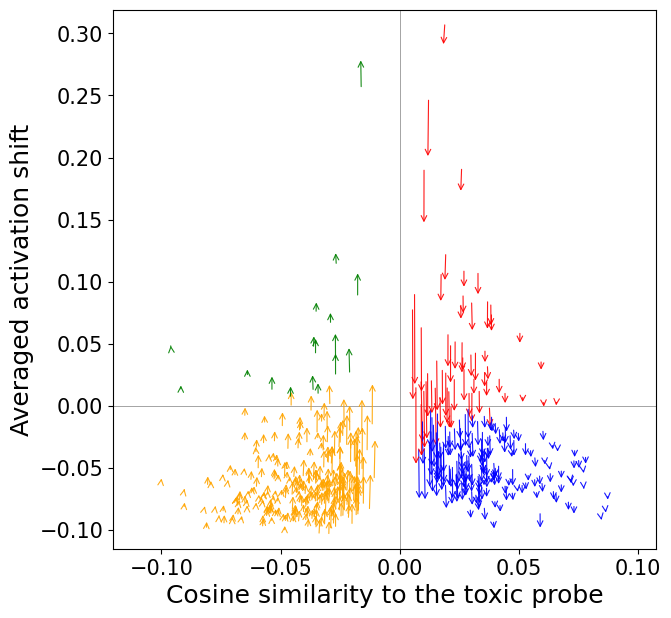

In [23]:
# Top contributing neurons
top_contrib = df.sort_values(by="projection_diff", ascending=False).iloc[5000:5500]

# Define x and y variables
x1 = top_contrib["pt_cossim"]
x2 = top_contrib["dpo_cossim"]

# Activation shift outlier removal for display
lower_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.005).min()
upper_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.995).max()

top_contrib = top_contrib[
    (top_contrib["pt_activation_value"].between(lower_q, upper_q)) &
    (top_contrib["dpo_activation_value"].between(lower_q, upper_q))
]

# - toxic neurons: positive cossim + activation drop
# - anti-toxic neurons: negative cossim + activation rise
top_contrib = top_contrib[
    ((top_contrib["pt_cossim"] > 0) & (top_contrib["dpo_activation_value"] < top_contrib["pt_activation_value"])) |
    ((top_contrib["pt_cossim"] < 0) & (top_contrib["dpo_activation_value"] > top_contrib["pt_activation_value"]))
]

# Final inputs for plot
x1 = top_contrib["pt_cossim"]
x2 = top_contrib["dpo_cossim"]
y1 = top_contrib["pt_activation_value"]
y2 = top_contrib["dpo_activation_value"]

# Use raw contribution values for line width
contrib = top_contrib["projection_diff"]
width_boost = 1.2
width = contrib * width_boost  # optionally scale if desired

fig, ax = plt.subplots(figsize=(7, 7))

# Increase label font size
ax.set_xlabel("Cosine similarity to the toxic probe", fontsize=18)
ax.set_ylabel("Averaged activation shift", fontsize=18)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=15)

_xpad = 0.02
_ypad = 0.01
ax.set_xlim(min(min(x1), min(x2)) - _xpad, max(max(x1), max(x2)) + _xpad)
ax.set_ylim(min(min(y1), min(y2)) - _ypad, max(max(y1), max(y2)) + _ypad)

ax.axhline(0, color="gray", lw=0.5)
ax.axvline(0, color="gray", lw=0.5)

for _x1, _x2, _y1, _y2, _contrib, _width in zip(x1, x2, y1, y2, contrib, width):
    if _x1 > 0:
        if _y1 > 0:
            color = "r"  # toxic neuron with positive activation
        else:
            color = "b"  # toxic neuron with negative activation
    else:
        if _y1 > 0:
            color = "g"  # anti-toxic neuron with positive activation
        else:
            color = "orange"  # anti-toxic neuron with negative activation

    ax.annotate(
        "",
        xy=(_x2, _y2),
        xytext=(_x1, _y1),
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            alpha=0.9,  # Add transparency
            linewidth=max(_width, 0.8),  # Ensure line is not too thin
        ),
    )


plt.show()


##### Stacked bar plot

#tp 3967
#tn 22444
#atp 1838
#atn 29252
#total 57501

tp   32%
tn   24%
atp  7%
atn  37%


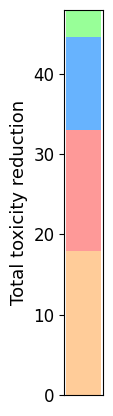

In [10]:
# %%
inc = df[df["projection_diff"] > 0]
# %%
tp = inc[(inc["pt_cossim"] > 0) & (inc["pt_activation"] > 0)]
tn = inc[(inc["pt_cossim"] > 0) & (inc["pt_activation"] <= 0)]
atp = inc[(inc["pt_cossim"] <= 0) & (inc["pt_activation"] > 0)]
atn = inc[(inc["pt_cossim"] <= 0) & (inc["pt_activation"] <= 0)]

print(f"#tp {len(tp)}")
print(f"#tn {len(tn)}")
print(f"#atp {len(atp)}")
print(f"#atn {len(atn)}")
print(f"#total {len(inc)}")
assert len(inc) == len(tp) + len(tn) + len(atp) + len(atn)

tp_sum = tp["projection_diff"].sum()
tn_sum = tn["projection_diff"].sum()
atp_sum = atp["projection_diff"].sum()
atn_sum = atn["projection_diff"].sum()
total_sum = inc["projection_diff"].sum()
print()
print(f"tp   {tp_sum/total_sum:.0%}")
print(f"tn   {tn_sum/total_sum:.0%}")
print(f"atp  {atp_sum/total_sum:.0%}")
print(f"atn  {atn_sum/total_sum:.0%}")


# bar plot of tp
fig, ax = plt.subplots(figsize=(0.5, 5))
ax.bar(0, atn_sum, label="anti-toxic negative", color="#FFCC99")
_b = atn_sum
ax.bar(0, tp_sum, bottom=_b, label="toxic positive", color="#FE9998")
_b += tp_sum
ax.bar(0, tn_sum, bottom=_b, label="toxic negative", color="#67B3FE")
_b += tn_sum
ax.bar(0, atp_sum, bottom=_b, label="anti-toxic positive", color="#98FF98")
_b += atp_sum

# set lim
ax.set_ylim(0, total_sum)
# y axis total group contribution
ax.set_ylabel("Total toxicity reduction", fontsize=13)
# remove x ticks
ax.set_xticks([])
# Increase the size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# axs.append(ax)

##### Per-layer graphs

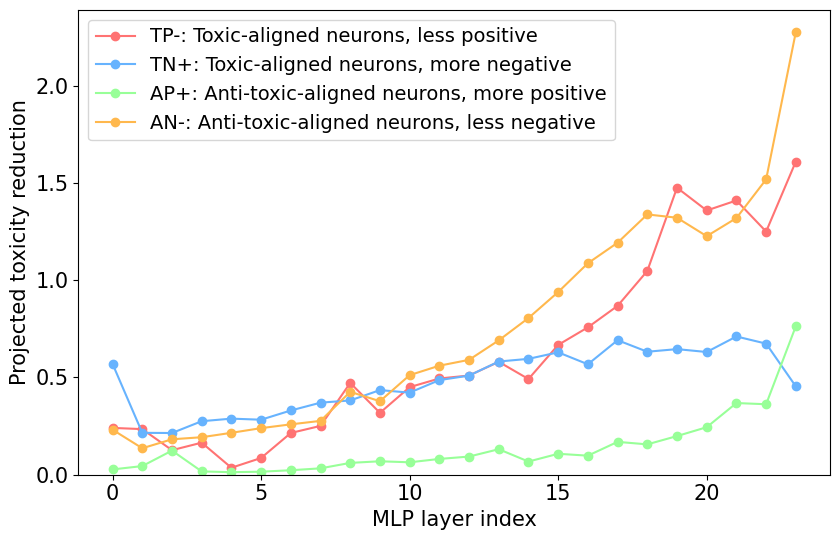

In [6]:
# Define group colors for consistency
colors = ['#FF7373', '#67B3FE', '#98FF98', '#FFB84D']
group_labels = ['toxic positive', 'toxic negative', 'anti-toxic positive', 'anti-toxic negative']

# Initialize lists to store the sums of projection_diff for each group in each layer
tp_sums, tn_sums, atp_sums, atn_sums = [], [], [], []

# Iterate through each layer and compute the projection_diff sums for each group
layers_to_plot = range(24)

for layer in layers_to_plot:
    # Filter neurons by layer
    layer_df = df[df['layer_idx'] == layer]

    # Filter data for positive projection differences
    inc = layer_df[layer_df["projection_diff"] > 0]

    # Apply the same filtering as before
    tp = inc[(inc["pt_cossim"] > 0) & (inc["pt_activation"] > 0)]
    tn = inc[(inc["pt_cossim"] > 0) & (inc["pt_activation"] <= 0)]
    atp = inc[(inc["pt_cossim"] <= 0) & (inc["pt_activation"] > 0)]
    atn = inc[(inc["pt_cossim"] <= 0) & (inc["pt_activation"] <= 0)]
    
    # Calculate the sum of projection_diff for each group in this layer
    tp_sums.append(tp["projection_diff"].sum())
    tn_sums.append(tn["projection_diff"].sum())
    atp_sums.append(atp["projection_diff"].sum())
    atn_sums.append(atn["projection_diff"].sum())

# Prepare data for plotting the lines for each group
fig, ax = plt.subplots(figsize=(8.5, 5.5))

# Plot lines for each group
ax.plot(layers_to_plot, tp_sums, label='TP-: Toxic-aligned neurons, less positive', color=colors[0], marker='o')
ax.plot(layers_to_plot, tn_sums, label='TN+: Toxic-aligned neurons, more negative', color=colors[1], marker='o')
ax.plot(layers_to_plot, atp_sums, label='AP+: Anti-toxic-aligned neurons, more positive', color=colors[2], marker='o')
ax.plot(layers_to_plot, atn_sums, label='AN-: Anti-toxic-aligned neurons, less negative', color=colors[3], marker='o')

# Add a horizontal line at y=0 for clarity
# ax.axhline(y=0, color='black', linestyle='--')

# Set labels and title
ax.set_xlabel('MLP layer index', fontsize=15)
ax.set_ylabel('Projected toxicity reduction', fontsize=15)
# ax.set_title('Toxicity reduction per layer contributed by neuron groups', fontsize=14)

# Add a legend to indicate which line corresponds to which group
ax.legend(fontsize=14)

# Set xticks and yticks with increased font size
ax.set_xticks(range(0, 25, 5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Define y-axis limits to start from 0
ax.set_ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()

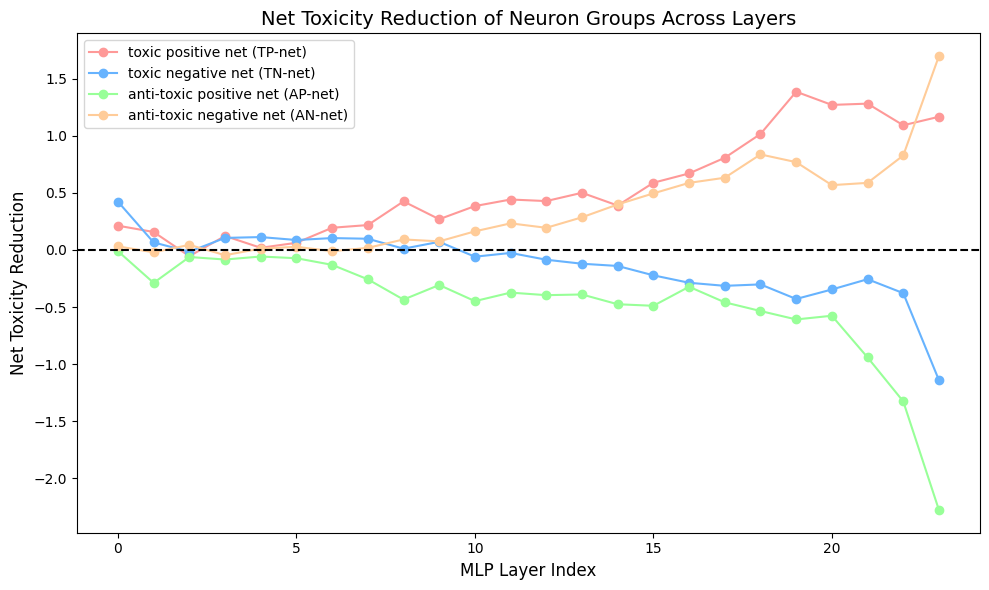

In [22]:
# Define group colors for consistency
colors = ['#FE9998', '#67B3FE', '#98FF98', '#FFCC99']
group_labels = ['toxic positive', 'toxic negative', 'anti-toxic positive', 'anti-toxic negative']

# Initialize lists to store the sums of projection_diff for each group in each layer
tp_sums, tn_sums, atp_sums, atn_sums = [], [], [], []

# Iterate through each layer and compute the projection_diff sums for each group
layers_to_plot = range(24)

for layer in layers_to_plot:
    # Filter neurons by layer
    layer_df = df[df['layer_idx'] == layer]

    # Apply the same filtering as before, but without filtering out projection_diff <= 0
    tp = layer_df[(layer_df["pt_cossim"] > 0) & (layer_df["pt_activation"] > 0)]
    tn = layer_df[(layer_df["pt_cossim"] > 0) & (layer_df["pt_activation"] <= 0)]
    atp = layer_df[(layer_df["pt_cossim"] <= 0) & (layer_df["pt_activation"] > 0)]
    atn = layer_df[(layer_df["pt_cossim"] <= 0) & (layer_df["pt_activation"] <= 0)]

    # Calculate the sum of projection_diff for each group in this layer
    tp_sums.append(tp["projection_diff"].sum())
    tn_sums.append(tn["projection_diff"].sum())
    atp_sums.append(atp["projection_diff"].sum())
    atn_sums.append(atn["projection_diff"].sum())

# Prepare data for plotting the lines for each group
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lines for each group
ax.plot(layers_to_plot, tp_sums, label='toxic positive net (TP-net)', color=colors[0], marker='o')
ax.plot(layers_to_plot, tn_sums, label='toxic negative net (TN-net)', color=colors[1], marker='o')
ax.plot(layers_to_plot, atp_sums, label='anti-toxic positive net (AP-net)', color=colors[2], marker='o')
ax.plot(layers_to_plot, atn_sums, label='anti-toxic negative net (AN-net)', color=colors[3], marker='o')

# Add a horizontal line at y=0 for clarity
ax.axhline(y=0, color='black', linestyle='--')

# Set labels and title
ax.set_xlabel('MLP Layer Index', fontsize=12)
ax.set_ylabel('Net Toxicity Reduction', fontsize=12)
ax.set_title('Net Toxicity Reduction of Neuron Groups Across Layers', fontsize=14)

# Add a legend to indicate which line corresponds to which group
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


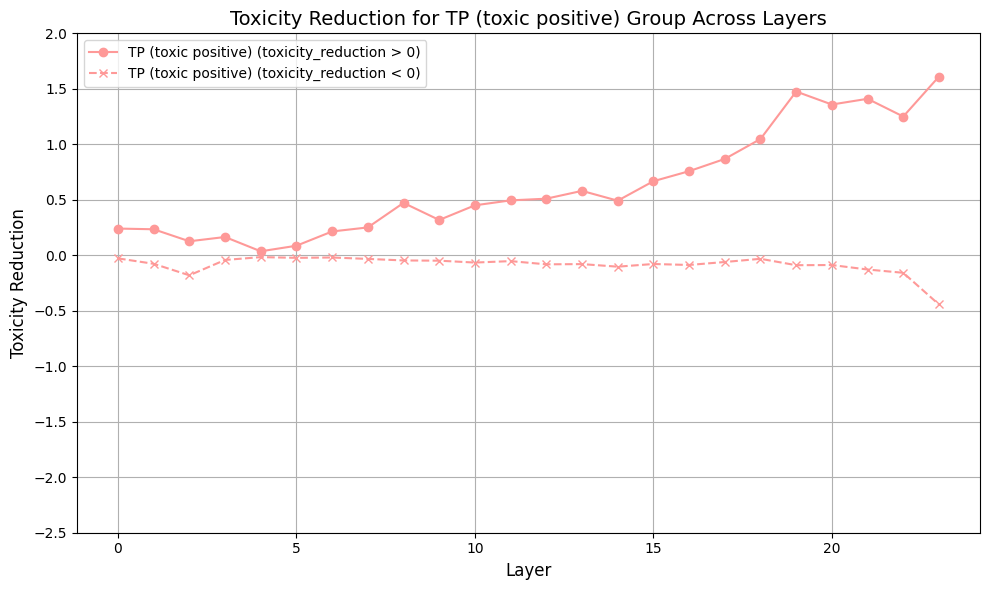

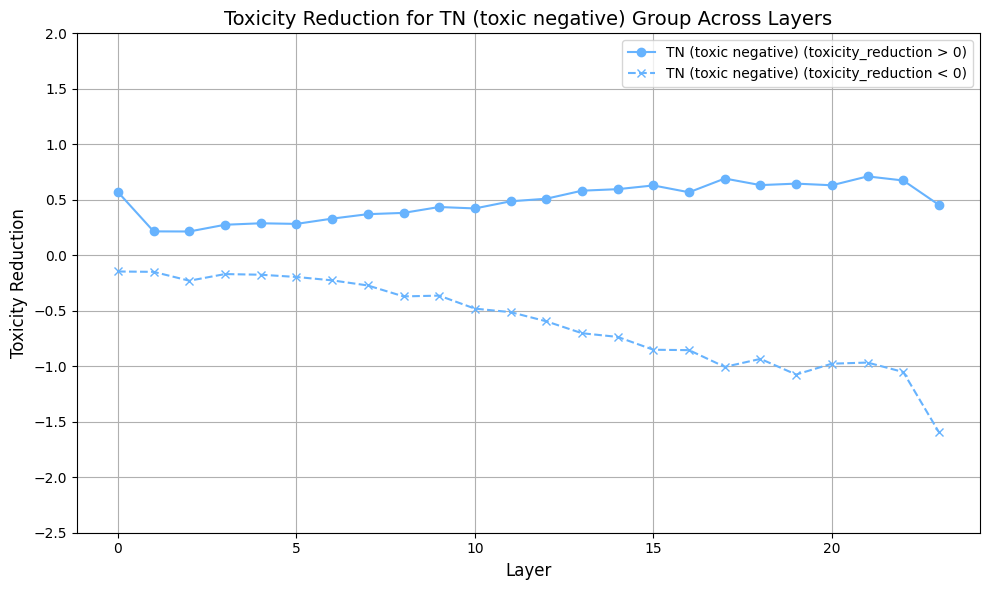

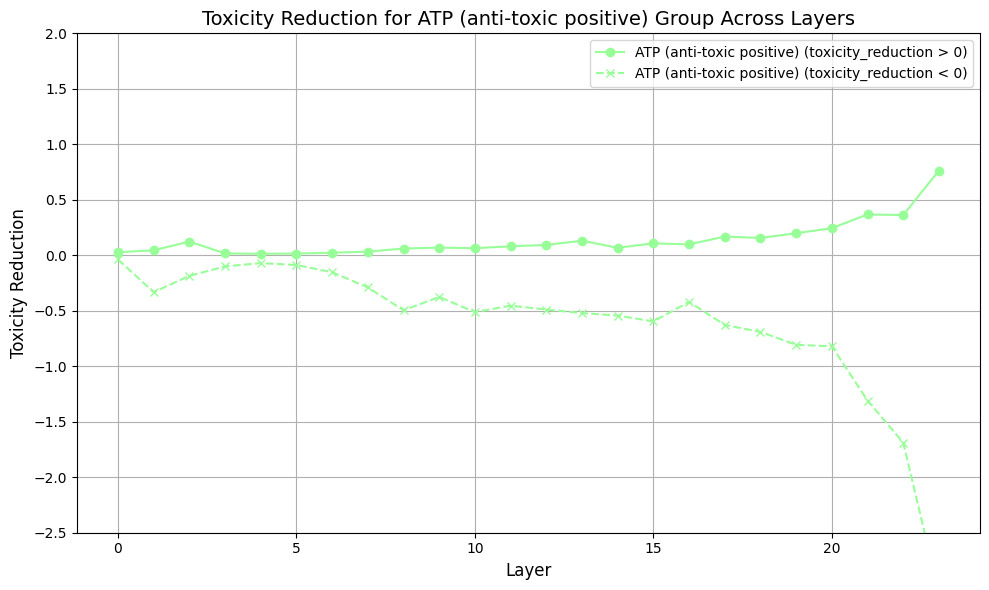

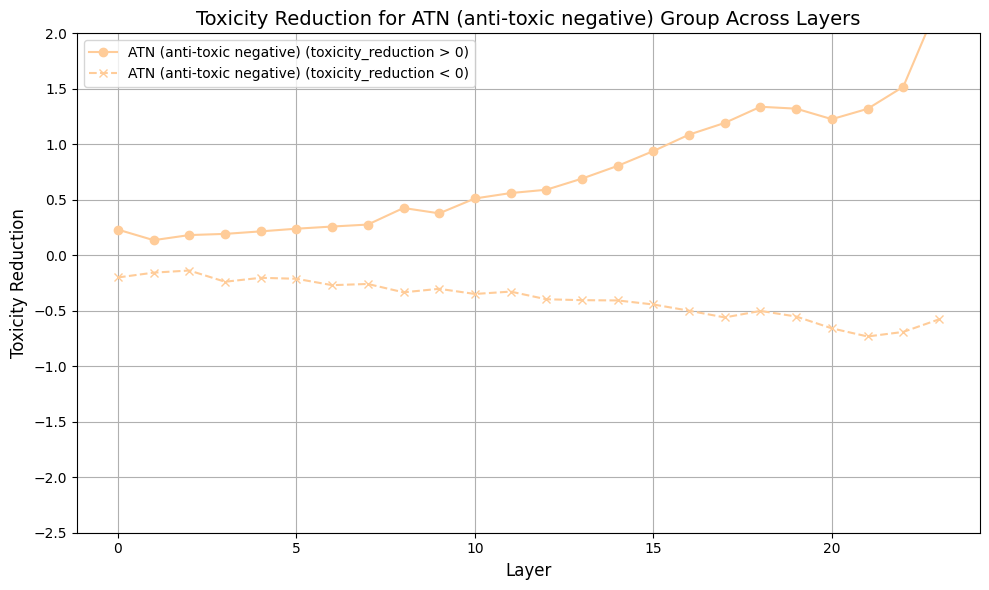

In [29]:
# Prepare lists to store the sums of projection_diff > 0 and projection_diff < 0 for each group
tp_sums_positive, tp_sums_negative = [], []
tn_sums_positive, tn_sums_negative = [], []
atp_sums_positive, atp_sums_negative = [], []
atn_sums_positive, atn_sums_negative = [], []

# Iterate through each layer and calculate the sum of projection_diff for each group
layers_to_plot = range(24)

for layer in layers_to_plot:
    # Filter neurons by layer
    layer_df = df[df['layer_idx'] == layer]

    # TP Group (toxic positive)
    tp = layer_df[(layer_df["pt_cossim"] > 0) & (layer_df["pt_activation"] > 0)]
    tp_positive_sum = tp[tp["projection_diff"] > 0]["projection_diff"].sum()
    tp_negative_sum = tp[tp["projection_diff"] < 0]["projection_diff"].sum()
    tp_sums_positive.append(tp_positive_sum)
    tp_sums_negative.append(tp_negative_sum)

    # TN Group (toxic negative)
    tn = layer_df[(layer_df["pt_cossim"] > 0) & (layer_df["pt_activation"] <= 0)]
    tn_positive_sum = tn[tn["projection_diff"] > 0]["projection_diff"].sum()
    tn_negative_sum = tn[tn["projection_diff"] < 0]["projection_diff"].sum()
    tn_sums_positive.append(tn_positive_sum)
    tn_sums_negative.append(tn_negative_sum)

    # ATP Group (anti-toxic positive)
    atp = layer_df[(layer_df["pt_cossim"] <= 0) & (layer_df["pt_activation"] > 0)]
    atp_positive_sum = atp[atp["projection_diff"] > 0]["projection_diff"].sum()
    atp_negative_sum = atp[atp["projection_diff"] < 0]["projection_diff"].sum()
    atp_sums_positive.append(atp_positive_sum)
    atp_sums_negative.append(atp_negative_sum)

    # ATN Group (anti-toxic negative)
    atn = layer_df[(layer_df["pt_cossim"] <= 0) & (layer_df["pt_activation"] <= 0)]
    atn_positive_sum = atn[atn["projection_diff"] > 0]["projection_diff"].sum()
    atn_negative_sum = atn[atn["projection_diff"] < 0]["projection_diff"].sum()
    atn_sums_positive.append(atn_positive_sum)
    atn_sums_negative.append(atn_negative_sum)

# Function to plot the projection_diff for a group with the same color for both lines
def plot_group(group_name, pos_sums, neg_sums, group_color):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot lines for positive and negative projection_diff sums with the same color
    ax.plot(layers_to_plot, pos_sums, label=f'{group_name} (toxicity_reduction > 0)', color=group_color, marker='o')
    ax.plot(layers_to_plot, neg_sums, label=f'{group_name} (toxicity_reduction < 0)', color=group_color, linestyle='--', marker='x')
    
    # Set the y-axis limits to be between -2.5 and 2
    ax.set_ylim(-2.5, 2)
    
    # Add labels, title, and legend
    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel('Toxicity Reduction', fontsize=12)
    ax.set_title(f'Toxicity Reduction for {group_name} Group Across Layers', fontsize=14)
    ax.legend()
    
    # Add grid for better readability
    ax.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot for each group, using the same color for positive and negative projection_diff lines
plot_group('TP (toxic positive)', tp_sums_positive, tp_sums_negative, "#FE9998")
plot_group('TN (toxic negative)', tn_sums_positive, tn_sums_negative, "#67B3FE")
plot_group('ATP (anti-toxic positive)', atp_sums_positive, atp_sums_negative, "#98FF98")
plot_group('ATN (anti-toxic negative)', atn_sums_positive, atn_sums_negative, "#FFCC99")


/tmp/ipykernel_875815/2289633454.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, ha='right', fontsize=12)


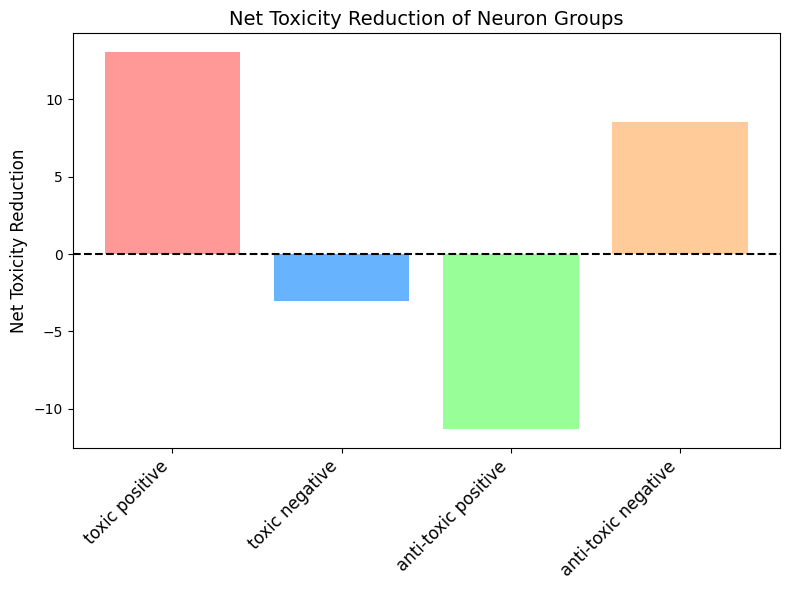

In [18]:
# Calculate the net sums across all layers for the four groups
tp = df[(df["pt_cossim"] > 0) & (df["pt_activation"] > 0)]
tn = df[(df["pt_cossim"] > 0) & (df["pt_activation"] <= 0)]
atp = df[(df["pt_cossim"] <= 0) & (df["pt_activation"] > 0)]
atn = df[(df["pt_cossim"] <= 0) & (df["pt_activation"] <= 0)]

# Calculate the total sum of projection_diff for each group
tp_sum = tp["projection_diff"].sum()
tn_sum = tn["projection_diff"].sum()
atp_sum = atp["projection_diff"].sum()
atn_sum = atn["projection_diff"].sum()

# Prepare data for plotting
group_sums = [tp_sum, tn_sum, atp_sum, atn_sum]
group_labels = ['toxic positive', 'toxic negative', 'anti-toxic positive', 'anti-toxic negative']
colors = ['#FE9998', '#67B3FE', '#98FF98', '#FFCC99']

# Plot the net effect for all neurons across all layers
fig, ax = plt.subplots(figsize=(8, 6))

# Create a bar plot
ax.bar(group_labels, group_sums, color=colors)

# Add a horizontal line at y=0 for clarity
ax.axhline(y=0, color='black', linestyle='--')

# Set labels and title
ax.set_ylabel('Net Toxicity Reduction', fontsize=12)
ax.set_title('Net Toxicity Reduction of Neuron Groups', fontsize=14)

# Rotate x-axis labels for better visibility
ax.set_xticklabels(group_labels, rotation=45, ha='right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

##### Notes: 
(1) Green is always negative, is it the main tradeoff point?

(2) Blue decreases from positive (top 1 group) to negative, as another tradeoff point?

##### Frequency bar plot

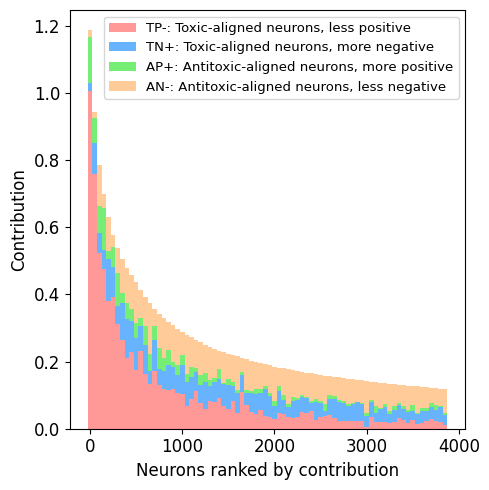

In [6]:
# Top 100-4000 contributing neurons (omit first 100 for better displaying)
chunk_size = 50
tp_contribs = []
tn_contribs = []
atp_contribs = []
atn_contribs = []
for i in range(100, 4000, chunk_size):
    chunk = df[i : i + chunk_size]
    tp = chunk[(chunk["pt_cossim"] > 0) & (chunk["pt_activation"] > 0)]
    tn = chunk[(chunk["pt_cossim"] > 0) & (chunk["pt_activation"] <= 0)]
    atp = chunk[(chunk["pt_cossim"] <= 0) & (chunk["pt_activation"] > 0)]
    atn = chunk[(chunk["pt_cossim"] <= 0) & (chunk["pt_activation"] <= 0)]
    tp_contribs.append(tp["projection_diff"].sum())
    tn_contribs.append(tn["projection_diff"].sum())
    atp_contribs.append(atp["projection_diff"].sum())
    atn_contribs.append(atn["projection_diff"].sum())
    
# bar plot of tp
fig, ax = plt.subplots(figsize=(5, 5))
x = np.arange(len(tp_contribs)) * chunk_size
# adjust width
w = 1.0 * chunk_size

# instead, stack bars one on another
ax.bar(x, tp_contribs, label="TP-: Toxic-aligned neurons, less positive", color="#FE9998", width=w)
_b = np.array(tp_contribs)
ax.bar(x, tn_contribs, bottom=_b, label="TN+: Toxic-aligned neurons, more negative", color="#67B3FE", width=w)
_b += np.array(tn_contribs)
ax.bar(x, atp_contribs, bottom=_b, label="AP+: Antitoxic-aligned neurons, more positive", color="#76EE76", width=w)
_b += np.array(atp_contribs)
ax.bar(x, atn_contribs, bottom=_b, label="AN-: Antitoxic-aligned neurons, less negative", color="#FFCC99", width=w)
ax.legend()

# label axes
ax.set_xlabel("Neurons ranked by contribution", fontsize=12)
ax.set_ylabel("Contribution", fontsize=12)

# Increasing the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Enlarging the legend
ax.legend(fontsize=9.5)

plt.tight_layout()
plt.show()

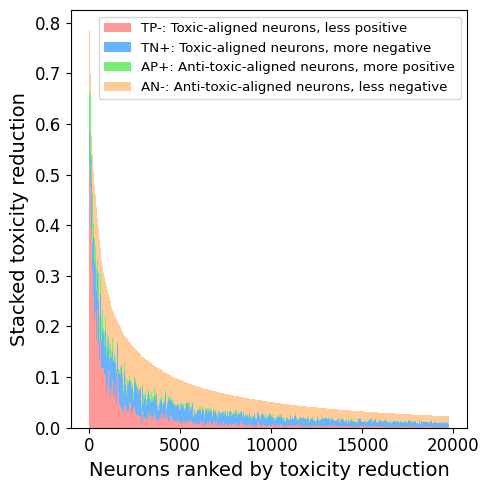

In [11]:
# Top 200-10000 contributing neurons (omit first 100 for better displaying)
chunk_size = 50
tp_contribs = []
tn_contribs = []
atp_contribs = []
atn_contribs = []
for i in range(200, 20000, chunk_size):
    chunk = df[i : i + chunk_size]
    tp = chunk[(chunk["pt_cossim"] > 0) & (chunk["pt_activation"] > 0)]
    tn = chunk[(chunk["pt_cossim"] > 0) & (chunk["pt_activation"] <= 0)]
    atp = chunk[(chunk["pt_cossim"] <= 0) & (chunk["pt_activation"] > 0)]
    atn = chunk[(chunk["pt_cossim"] <= 0) & (chunk["pt_activation"] <= 0)]
    tp_contribs.append(tp["projection_diff"].sum())
    tn_contribs.append(tn["projection_diff"].sum())
    atp_contribs.append(atp["projection_diff"].sum())
    atn_contribs.append(atn["projection_diff"].sum())
    
# bar plot of tp
fig, ax = plt.subplots(figsize=(5, 5))
x = np.arange(len(tp_contribs)) * chunk_size
# adjust width
w = 1.0 * chunk_size

# instead, stack bars one on another
ax.bar(x, tp_contribs, label="TP-: Toxic-aligned neurons, less positive", color="#FE9998", width=w)
_b = np.array(tp_contribs)
ax.bar(x, tn_contribs, bottom=_b, label="TN+: Toxic-aligned neurons, more negative", color="#67B3FE", width=w)
_b += np.array(tn_contribs)
ax.bar(x, atp_contribs, bottom=_b, label="AP+: Anti-toxic-aligned neurons, more positive", color="#76EE76", width=w)
_b += np.array(atp_contribs)
ax.bar(x, atn_contribs, bottom=_b, label="AN-: Anti-toxic-aligned neurons, less negative", color="#FFCC99", width=w)
ax.legend()

# label axes
ax.set_xlabel("Neurons ranked by toxicity reduction", fontsize=14)
ax.set_ylabel("Stacked toxicity reduction", fontsize=14)

# Increasing the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Enlarging the legend
ax.legend(fontsize=9.6)

plt.tight_layout()
plt.show()